<h1> ANALYSIS OF FUNDAMENTAL DATA USING ARIMA  </h1>

In [1]:
import sys
sys.path.append("../getData")
sys.path.append("../../visualization")
sys.path.append("../functions")
sys.path.append("../writer")
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools
import math
import transformations
import bdStocks
import graficosJupyterNotebook as graficos
import numpy as np
import pandas as pd
import transformationsDataframes
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from  statsmodels.tsa.stattools import arma_order_select_ic  as select_order
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from scipy.stats import norm
import math
from datetime import timedelta
import numpy as np
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
import configparser
config = configparser.ConfigParser()
config.read('../../config.properties')
log_dir_excepciones = "../../"+config.get('LOGS_DIR', 'excepciones')
import writer

<h2>Configurable options:</h2>

In [2]:
exchange="MC"
indiceName="ibex35"
getsectors=True
getdescriptions=False
columnas=["netIncome","totalRevenue","stock"]
columnasPrecios=["Adjusted_close","stock"]
tamMinimo=50
column="netIncome"
column2="Adjusted_close"
tam_train=0.8
periodicidad=4
nivel_confianza=0.1
max_lag=5
ponderaciones=[0.6,0.4]
transformar=False
periodoIndice="3M"
diasDeMargen=40

In [3]:
def contrasteCorrelacionResiduos(serie,diferenciacion,nivel_confianza):
    T=len(serie)-diferenciacion
    varSerie=1/T
    desv=math.sqrt(varSerie)
    nivel=norm.ppf(1-nivel_confianza/2)
    a= abs(serie)/desv<nivel

    return a

class Modelo:
    def __init__(self,modelo,modeloExtendido,significacionP=None,significacionQ=None,significacionPEst=None,significacionQEst=None):
        self.modelo=modelo
        self.modeloExtendido=modeloExtendido
        self.errorTrain=modelo.mse
        self.errorTest=modeloExtendido.mse
        self.aicTrain=modelo.aic
        self.aicTest=modeloExtendido.aic
        self.aicTotal=ponderaciones[0]*self.aicTrain+ponderaciones[1]*self.aicTest
        self.errorTotal=ponderaciones[0]+self.errorTrain*ponderaciones[1]*self.errorTest
        self.significacionP=significacionP
        self.significacionQ=significacionQ
        self.significacionPEst=significacionPEst
        self.significacionQEst=significacionQEst
def crearYProbarModelo(serie_train,serie_test,ordenes=None,ordenesSeason=None,diferenciacion=0,diferenciacionSeason=0,periodo=periodicidad):
    modelo=None
    notSeasonalTrend="c"
    seasonalTrend="c"
    if diferenciacion>0:
        notSeasonalTrend="t"
    if diferenciacionSeason>0:
        seasonalTrend="t"
        if ordenesSeason is None:
            ordenesSeason=(0,0)
        
    if  ordenes is not None:
        ordenes=(ordenes[0],diferenciacion,ordenes[1])
    if  ordenes is not None and ordenesSeason is not None:
        ordenesSeason=(ordenesSeason[0],diferenciacionSeason,ordenesSeason[1],periodo)
    if ordenesSeason is not None:
           ordenesSeason=(ordenesSeason[0],diferenciacionSeason,ordenesSeason[1],periodo)
    if  ordenes is not None and ordenesSeason is not None:   
        s="c"
        if notSeasonalTrend=="t" or  seasonalTrend=="t":
            s="t"
       
        modelo=ARIMA(endog=serie_train,order=ordenes,seasonal_order=ordenesSeason)
    elif ordenes is not None:
        modelo=ARIMA(endog=serie_train,order=ordenes,trend=notSeasonalTrend)
    elif ordenesSeason is not None:
        modelo=ARIMA(endog=serie_train,seasonal_order=ordenesSeason,trend= seasonalTrend)
    if modelo is not None:    
        
        adj=modelo.fit()
        adj2=adj.extend(serie_test.to_numpy())
        
        return adj,adj2

In [19]:
bd=bdStocks.getData()
precios=bd.getDataByExchange("precios",exchange,columnas=columnasPrecios,bd=True)
fundamentals=bd.getDataByExchange("fundamental",exchange,bd=False,columnas=columnas)
indice=bd.getIndexPrizes(indiceName)
#getsectors=False
if getsectors:
    sectors=bd.getSectors(exchange)
    fundamentals["sector"]=fundamentals["stock"].transform(lambda t:sectors[t])
if   getdescriptions:
    descriptions=bd.getDescriptions(exchange)
    fundamentals["description"]=fundamentals["stock"].transform(lambda t:descriptions[t])
#if not_index:
#    precios.reset_index(inplace=True)
#    fundamentals.reset_index(inplace=True)

Time: 03/22/2022, 21:26 Message: BD access time to get precios 4.854593753814697

Time: 03/22/2022, 21:26 Message: Object size (precios data)63.605618 MB

Time: 03/22/2022, 21:26 Message: CSV access time to get fundamental 2.680504083633423

Time: 03/22/2022, 21:26 Message: Object size (fundamental data)5.571425 MB

Time: 03/22/2022, 21:26 Message: BD access time to sectors 0.1529393196105957



In [22]:
fundamentals.tail()

,netIncome,totalRevenue,stock,sector
fecha,,,,
2020-11-30,37204000.0,205190000.0,ZOT,Industrials
2021-02-28,33000000.0,197400000.0,ZOT,Industrials
2021-05-31,33411000.0,205034000.0,ZOT,Industrials
2021-08-31,41589000.0,203566000.0,ZOT,Industrials
2021-11-30,39120000.0,NaN,ZOT,Industrials


In [10]:
sectors=np.unique(fundamentals["sector"])
dataframeAnalysis=fundamentals.loc[fundamentals["sector"].isin([sectors[-6]])]
stocks=[e for e in np.unique(dataframeAnalysis["stock"]) if (dataframeAnalysis.loc[dataframeAnalysis["stock"]==e]).shape[0]>tamMinimo]
print(stocks)
stocks=iter(stocks)
dataframeAnalysis.shape


['ALB', 'BBVA', 'BKT', 'CABK', 'GCO', 'MAP', 'SAN', 'UNI']


(668, 4)

In [15]:
stock=next(stocks)
data1=dataframeAnalysis.loc[dataframeAnalysis["stock"]==stock,[column]]
data2=precios.loc[precios["stock"]==stock,["Adjusted_close"]]
data2= transformationsDataframes.pasarAMensual(data2)
data1=transformationsDataframes.pasarAMensual(data1)
data3=data1.join(data2).fillna(method="ffill")
nas=0
nas+=int(data1.isna().sum())

Stock BBVA
(80, 1)


,netIncome,Adjusted_close
netIncome,1.00000,0.20422
Adjusted_close,0.20422,1.00000


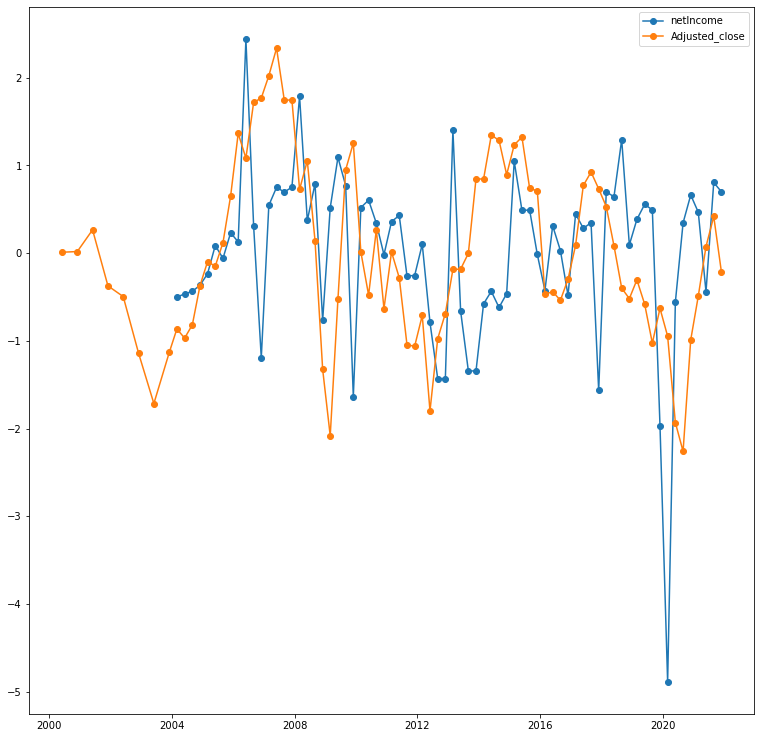

In [16]:
print("Stock %s"%stock)
data=dataframeAnalysis.loc[dataframeAnalysis["stock"]==stock,[column]]
print(data.shape)
data=data.fillna(method='ffill')/1000000
nas-=int(data.isna().sum())
data=data.dropna()
dataOriginal=data.copy()
data3=(data3-data3.mean())/data3.std()
fig=plt.figure(figsize=(13,13))
plt.plot(data3.index,data3[column],label=column,marker="o")
plt.plot(data3.index,data3[column2],marker="o",label=column2)
plt.legend()
data3.corr()

a
-1792.0


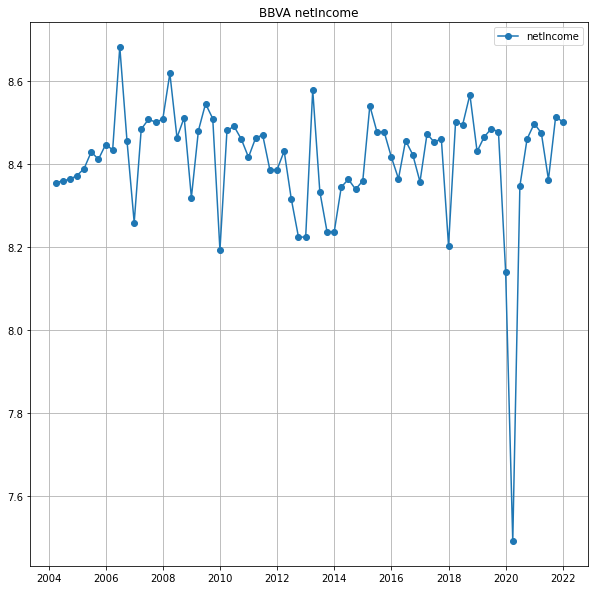

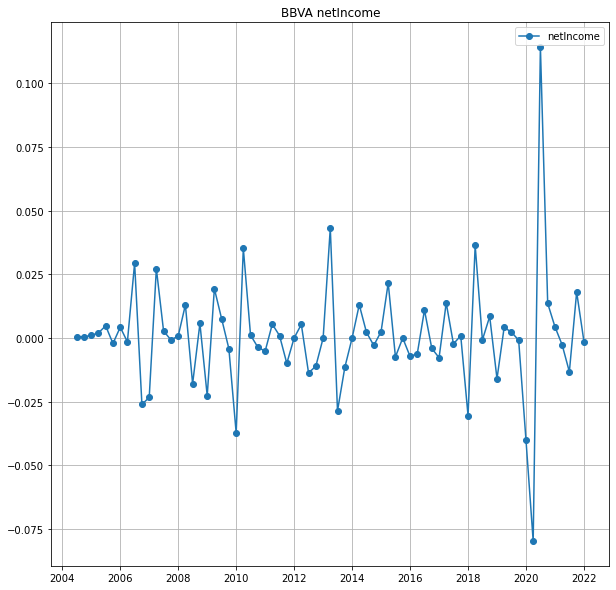

-1792.0


In [17]:
transformar=bool(input())
if transformar:
    minimo=np.min(data)[0]
    if minimo<0:
        print(minimo)
        data=data-minimo*2
    boxcox=transformations.boxcox
    data1=(data).applymap(lambda x:(boxcox(0,x)))
    graficos.linearplot(data1,stock+" "+column,False,column)
    graficos.linearplot(data1.transform(lambda x:x.pct_change()),stock+" "+column,False,column)
    print(minimo)
else:
    data1=data.copy()
data1=transformationsDataframes.pasarAMensual(data1)
all_days = pd.date_range(data1.index[0], data1.index[-1]+timedelta(days=diasDeMargen),freq=periodoIndice,normalize=True)
all_days=all_days.map(lambda x:x.replace(day=1))
nas+=len(all_days)-len(data1.index)
data1=data1.reindex(all_days)
serie=data1[column].fillna(method="ffill").dropna()
tam=len(serie)
lim_train=int(tam*tam_train)
serie_train=serie[:lim_train]
serie_test=serie[lim_train:]


In [28]:
(nas,len(serie))

(4, 72)

In [18]:
diferenciacion=0
diferenciacionEstacional=0
estacional=True
paramFuller=5
adf=adfuller(serie_train,maxlag=max_lag)
adf
posibleEstacionaridad=False
diferenciacion=0
diferenciacionEstacional=0
if adf[1]>nivel_confianza:
    posibleEstacionaridad=True
    
if posibleEstacionaridad and estacional:
    serie1=pd.Series(serie_train).diff(periodicidad).dropna()
    adf1=adfuller(serie1,maxlag=max_lag)
if posibleEstacionaridad:
    serie2=pd.Series(serie_train).diff(1).dropna()
    adf2=adfuller(serie2,maxlag=max_lag)
    print(adf1)
    print(adf2)
if posibleEstacionaridad and estacional:
    niveles=[0.0001,0.001,0.01,0.05,0.01]
    for idx,nivel in enumerate(niveles[1:]):
            print(nivel,idx)
            if adf1[1]<nivel:
                diferenciacionEstacional=1
                break
            elif adf2[1]<niveles[idx]:
                diferenciacion=1
                break
    if diferenciacion==0 and diferenciacionEstacional==0:
            serie3=pd.Series(serie1).diff(1).dropna()
            adf3=adfuller(serie3,maxlag=max_lag)
            print(adf3)
            if adf3[0]<adf3[4]["5%"]:
                diferenciacionEstacional=1
                diferenciacion=1
            else:
                serie_train=None

print(diferenciacion,diferenciacionEstacional)
        
import matplotlib.pyplot as plt
#plt.plot(serie)

(-4.8856212594599935, 3.719290502498613e-05, 3, 49, {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}, -70.11879556879506)
(-9.13319187005934, 2.9835798593764527e-15, 2, 53, {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}, -76.85252300979943)
0.001 0
0 1


56
0.1336306209562122
[7.48331477 2.23583107 0.27067119 0.23073333 0.77222143 0.46106223
 0.03550292 0.73551472 0.58156672 1.24969991 0.74940656 0.35899712
 0.17294339 1.05676945 0.98267047 0.50627454 0.40944295 0.95305259
 0.49720986] [7.48331477 2.27648254 0.45382575 0.21712245 0.74493641 0.03326807
 0.12572265 1.02072367 1.30908776 0.96284734 0.15209262 1.06881243
 0.44254305 1.24754405 0.73703541 1.69666761 0.09315388 2.56720042
 0.45059554]
1.2815515655446004


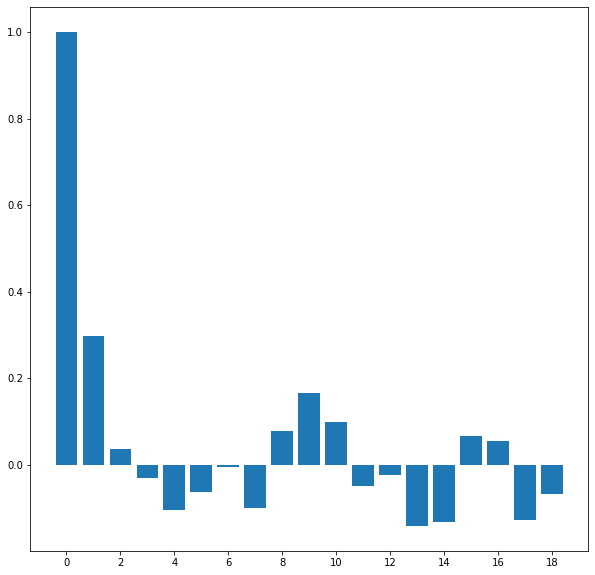

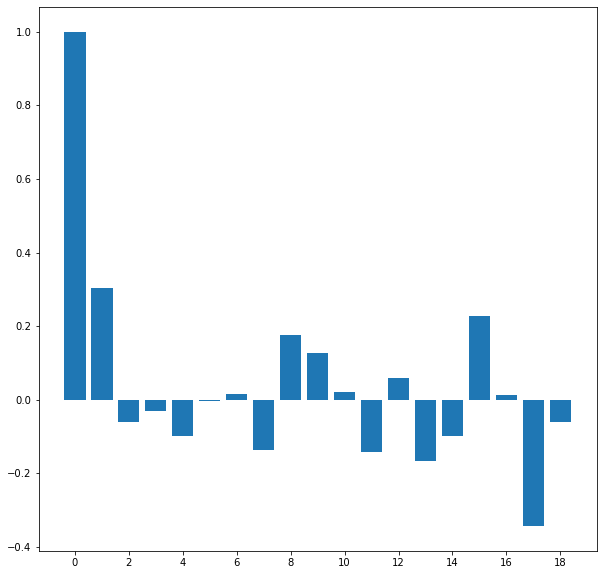

In [13]:
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
serie1=serie_train.copy()
if diferenciacion and  diferenciacionEstacional:
    serie1=serie_train.diff(periodicidad).diff(1)
elif diferenciacion:
    serie1=serie_train.diff(1)
elif diferenciacionEstacional:
    serie1=serie_train.diff(periodicidad)
serie1=serie1.dropna() 
corr=acf(serie1,nlags=int(len(serie1)/3))
pcorr=pacf(serie1,nlags=int(len(serie1)/3))
nivel=norm.ppf(0.90)
def devolverEstadisticos(corr,pcorr,diferenciacion,serie):
    T=len(serie)-diferenciacion
    print(T)
    varSerie=1/T
    desv=math.sqrt(varSerie)
    print(desv)
    return abs(corr)/desv,abs(pcorr)/desv
estCorr,estPcorr=(devolverEstadisticos(corr,pcorr,diferenciacion,serie1))
print(estCorr,estPcorr)
print(nivel)
graficos.correlograma(corr,pcorr)

In [32]:
from scipy.stats import norm
import itertools
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf

def reglas(serie_train,serie_test,estCorr,estPcorr,nivel_confianza,diferenciacion,diferenciacionSeason):
    nivel=norm.ppf(1-nivel_confianza/2)
    ordenesp={}
    ordenesq={}
    ordenespEstacional={}
    ordenesq={}
    ordenesqEstacional={}
    modelos={}
    for k in range(max_lag,0,-1): 
        if abs(estCorr[k])>nivel:

            ordenesp={i:norm.cdf(abs(estCorr[i]))-(1-norm.cdf(abs(estCorr[i]))) for i in range(1,k+1)}
            break

    for k in range(max_lag,0,-1): 
        if abs(estPcorr[k])>nivel:

            ordenesq={i:norm.cdf(abs(estPcorr[i]))-(1-norm.cdf(abs(estPcorr[i]))) for i in range(1,k+1)}
            break
        #ordenesq={1:0.5}
    v=4
    L=min(len(estCorr)-1,v*periodicidad)  
    for k in range(L,periodicidad-1,-1): 
        if abs(estCorr[k])>nivel:
          
            l=int(k/periodicidad)
            if l not in  ordenesqEstacional.keys():
                ordenespEstacional[l]=norm.cdf(abs(estCorr[k]))-(1-norm.cdf(abs(estCorr[k])))
            

         
    for k in range(L,periodicidad-1,-1): 
     
       if abs(estPcorr[k])>nivel:
         
            l=int(k/periodicidad)
            if l not in  ordenesqEstacional.keys():
                ordenesqEstacional[l]=norm.cdf(abs(estCorr[k]))-(1-norm.cdf(abs(estCorr[k])))
          
        #ordenesq={1:0.5}
   
        
        
    lista=[]
    listaEstacional=[]
    if len(ordenesp.keys())>0 and len(ordenesq.keys())>0:
        grid=np.meshgrid(list(ordenesp.keys()),list(ordenesq.keys()))
        lista=[[grid[0][k][i],grid[1][k][i]] for k in range(len(grid[0])) for i in range(len(grid[0][k]))]
    elif len(ordenesp.keys())>0:
         lista=[[e,0] for e in ordenesp.keys() ]

    elif len(ordenesq.keys())>0:
         lista=[[0,e] for e in ordenesq.keys() ]
   
    if len(ordenespEstacional.keys())>0 and len(ordenesqEstacional.keys())>0:
        grid=np.meshgrid(list(ordenespEstacional.keys()),list(ordenesqEstacional.keys()))
        listaEstacional=[[grid[0][k][i],grid[1][k][i]] for k in range(len(grid[0])) for i in range(len(grid[0][k]))]
    elif len(ordenespEstacional.keys())>0:
         listaEstacional=[[e,0] for e in ordenespEstacional.keys() ]

    elif len(ordenespEstacional.keys())>0:
         listaEstacional=[[0,e] for e in ordenesqEstacional.keys() ]
    modelos=[]
    print(lista,listaEstacional)
    for orde in lista:
        try:
            if (diferenciacionSeason==0) or (diferenciacionSeason>0 and orde[0]<periodicidad and orde[1]<periodicidad):
                adj,adj2=crearYProbarModelo(serie_train,serie_test,ordenes=orde,ordenesSeason=None,diferenciacion=diferenciacion,diferenciacionSeason=diferenciacionSeason)
                sigP=None
                sigQ=None
                if orde[0]!=0:
                    sigP=   ordenesp[orde[0]]
                if orde[1]!=0:
                    sigQ= ordenesq[orde[1]]
                modelo=Modelo(adj,adj2, sigP,sigQ)
                modelos.append(modelo)
        except Exception as e:
                writer.write(e,
                     log_dir_excepciones)
    
    for ordeEst in listaEstacional:
        try:
            adj,adj2=crearYProbarModelo(serie_train,serie_test,ordenes=None,ordenesSeason=ordeEst,diferenciacion=diferenciacion,diferenciacionSeason=diferenciacionSeason)   
        except Exception as e:
                writer.write(e,
                     log_dir_excepciones)
        for orde in lista:
            try:
                if orde[0]<4 and orde[1]<4:
                    #print(orde,ordeEst)
                    adj,adj2=crearYProbarModelo(serie_train,serie_test,ordenes=orde,ordenesSeason=ordeEst,diferenciacion=diferenciacion,diferenciacionSeason=diferenciacionSeason)
                    sigP=None
                    sigQ=None
                    if orde[0]!=0:
                        sigP=   ordenesp[orde[0]]
                    if orde[1]!=0:
                        sigQ= ordenesq[orde[1]]
                    sigPEst=None
                    sigQEst=None
                    if ordeEst[0]!=0:
                        sigPEst=   ordenespEstacional[ordeEst[0]]
                    if ordeEst[1]!=0:
                        sigQESt= ordenesqEstacional[ordeEst[1]]
                    modelo=Modelo(adj,adj2, sigP,sigQ, sigPEst,sigQEst)
                    modelos.append(modelo)
            except Exception as e:
                writer.write(e,
                     log_dir_excepciones)
                    
       
    
    
  
    return modelos
    
    
#diferenciacionEstacional=1
#diferenciacion=1
modelos=reglas(serie_train,serie_test,estCorr,estPcorr,nivel_confianza,diferenciacion,diferenciacionEstacional)

[[1, 1], [2, 1], [3, 1], [4, 1], [5, 1], [1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [1, 3], [2, 3], [3, 3], [4, 3], [5, 3], [1, 4], [2, 4], [3, 4], [4, 4], [5, 4]] [[1, 3], [1, 2], [1, 1]]


-74.86624143174699 ar.L1      0.742447
ma.L1     -0.348092
ma.S.L4   -0.758003
sigma2     0.011176
dtype: float64 {'seasonal_periods': 4, 'measurement_error': False, 'time_varying_regression': False, 'simple_differencing': False, 'enforce_stationarity': True, 'enforce_invertibility': True, 'hamilton_representation': False, 'concentrate_scale': False, 'trend_offset': 1, 'order': (1, 0, 1), 'seasonal_order': (0, 1, 1, 4), 'k_diff': 0, 'k_seasonal_diff': 1, 'k_ar': 1, 'k_ma': 1, 'k_seasonal_ar': 0, 'k_seasonal_ma': 4, 'k_ar_params': 1, 'k_ma_params': 1, 'trend': 'n', 'k_trend': 0, 'k_exog': 0, 'mle_regression': False, 'state_regression': False} 2.191424110655181
7.684529013241539e-15
3.842264506620769e-15
7.022140199794411e-185
0.7729850615273169
1989-09-01    0.000000e+00
1989-12-01    5.079805e-08
1990-03-01    7.467126e-08
1990-06-01    7.372329e-08
1990-09-01    7.529406e+00
1990-12-01    7.530993e+00
1991-03-01    7.528355e+00
1991-06-01    7.531735e+00
1991-09-01    7.531413e+00
199

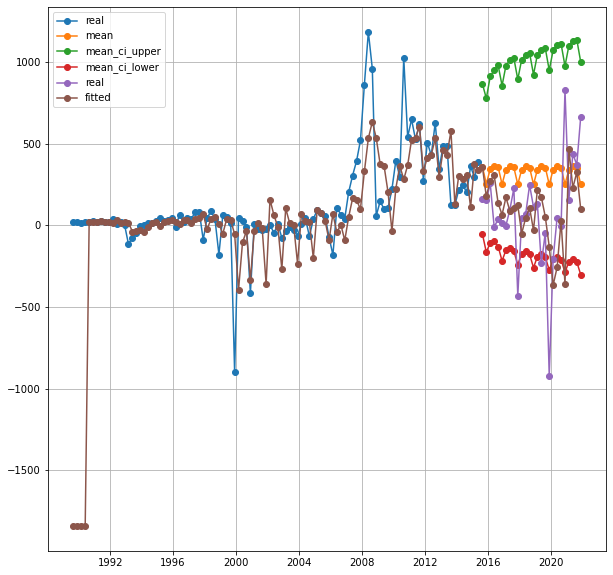

In [36]:
modelos.sort(key=lambda t:t.aicTotal)
import matplotlib.pyplot as plt
if transformar:
    serie_train1=serie_train.map(lambda x:(math.exp(x)+2*minimo))
    serie_test1=serie_test.map(lambda x:(math.exp(x)+2*minimo))
else:
    serie_train1=serie_train
    serie_test1=serie_test
    
for modelo in modelos[:1]:
    print(modelo.aicTotal,modelo.modelo.params,modelo.modelo.specification,modelo.modelo.mse)
    print(modelo.modelo.test_heteroskedasticity("breakvar",alternative= "two-sided")[0][1])
    print(modelo.modelo.test_heteroskedasticity("breakvar",alternative= "increasing")[0][1])
    print(modelo.modelo.test_normality(method="jarquebera")[0][1])
    u=(modelo.modelo.test_serial_correlation(method="ljungbox"))[0]
    print(np.mean(u[1]))
    dataframePred=modelo.modelo.get_forecast(len(serie_test1)).summary_frame()
    if transformar:
        dataframePred=dataframePred.applymap(lambda x:(math.exp(x)+2*minimo))
    dataframePred["real"]= serie_test1  
    primero=modelo.modelo.fittedvalues
    segundo=modelo.modeloExtendido.fittedvalues
    if transformar:
             primero=primero.map(lambda x:(math.exp(x)+2*minimo))
             segundo=segundo.map(lambda x:(math.exp(x)+2*minimo))
     
    graficos.plot_forecast(serie_train1,dataframePred,pd.concat([primero,segundo]))
    print(modelo.modelo.predict())

In [38]:
serie_test

2015-09-01    7.601902
2015-12-01    7.599401
2016-03-01    7.649121
2016-06-01    7.513054
2016-09-01    7.539665
2016-12-01    7.525047
2017-03-01    7.518118
2017-06-01    7.570082
2017-09-01    7.635062
2017-12-01    7.251983
2018-03-01    7.541312
2018-06-01    7.554806
2018-09-01    7.644680
2018-12-01    7.577787
2019-03-01    7.587209
2019-06-01    7.383306
2019-09-01    7.494375
2019-12-01    6.825460
2020-03-01    7.401842
2020-06-01    7.544015
2020-09-01    7.515236
2020-12-01    7.889796
2021-03-01    7.600252
2021-06-01    7.731580
2021-09-01    7.702511
2021-12-01    7.826762
Name: netIncome, dtype: float64